## Detect AI images

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode



In [ ]:

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 61

seed_everything(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used :", device)

In [3]:



arise_df = pd.read_csv('/kaggle/input/good-df-for-arise/good_data_frame_ARISE.csv')[['patient_id','joint_id','jsn_score','erosion_score']]
# Reading the testing CSV file
df_test = pd.read_csv('/kaggle/input/for-classification-arise/eval_df.csv')
df_train = pd.read_csv('/kaggle/input/for-classification-arise/train_df.csv')
df_train = pd.merge(arise_df, df_train, on=['patient_id','joint_id'])
df_train['bbox'] = df_train['bbox'].apply(lambda x: torch.tensor(list(map(float, x.split('[')[1].split(']')[0].split(','))), dtype=torch.float32))
df_test['bbox'] = df_test['bbox'].apply(lambda x: torch.tensor(list(map(float, x.split('[')[1].split(']')[0].split(','))), dtype=torch.float32))

In [4]:
maxes, indices = torch.stack(df_train['bbox'].values.tolist()).max(axis=0)

In [5]:
def func(x):
    print(x)
    return x

In [6]:
# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
df_test['id'] = df_test[['patient_id','joint_id']]\
.apply(lambda x: '/kaggle/input/for-classification-arise/eval_cropped/'+str(x[0])+'_'+str(x[1])+'.jpeg', axis=1)

df_train['id'] = df_train[['patient_id','joint_id']]\
.apply(lambda x: '/kaggle/input/for-classification-arise/eval_cropped/'+str(x[0])+'_'+str(x[1])+'.jpeg', axis=1)

all_image_paths = df_train['id'].values
all_labels = df_train[['jsn_score','erosion_score']].values

# Splitting train/validation (95% / 5%)
train, val = train_test_split(df_train,
    test_size=0.1,
    random_state=seed,
    shuffle=False
)



/tmp/ipykernel_147/1375656398.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: '/kaggle/input/for-classification-arise/eval_cropped/'+str(x[0])+'_'+str(x[1])+'.jpeg', axis=1)
/tmp/ipykernel_147/1375656398.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: '/kaggle/input/for-classification-arise/eval_cropped/'+str(x[0])+'_'+str(x[1])+'.jpeg', axis=1)


# Augmentation


In [8]:

train_transforms = T.Compose([
    T.Resize(255, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(240),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_transforms = T.Compose([
    T.Resize(255, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(240),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

test_transforms = T.Compose([
    T.Resize(255, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(240),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [9]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient_id,joint_id,jsn_score,erosion_score,bbox,img_path = self.df.iloc[idx].values
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        joint_id, jsn_score, erosion_score\
        = torch.tensor(joint_id/42, dtype=torch.float32), torch.tensor(jsn_score, dtype=torch.float32), \
        torch.tensor(erosion_score, dtype=torch.float32)
        bbox = bbox/maxes
        return img, joint_id, jsn_score, erosion_score, bbox

class TestImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['id']
        img = Image.open(img_path).convert("RGB")
        patient_id, joint_id = img_path.split('/')[-1].split('.')[0].split('_')
        bbox = self.df.iloc[idx]['bbox']
        bbox = bbox/maxes
        if self.transform:
            img = self.transform(img)
            
        joint_id = torch.tensor(int(joint_id)/42, dtype=torch.float32)
        return img, patient_id, joint_id, bbox

# DataLoader

Shuffle the train data, not a test.  

In [12]:
import transformers
from PIL import Image

class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.featuer_extractor = models.resnet50(weights='IMAGENET1K_V2')

        self.jsn_head = nn.Sequential(
            nn.Linear(1005, 512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Linear(512, 5),
            nn.Softmax(dim=1)
        )

        self.erosion_head = nn.Sequential(
            nn.Linear(1005, 512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Linear(512, 6),
            nn.Softmax(dim=1)
        )

    def forward(self, x, joint_id, bbox):
        x = self.featuer_extractor(x)
        x = torch.cat([x, bbox, joint_id.unsqueeze(1)], dim=1)
        jsn_pred = self.jsn_head(x)
        erosion_pred = self.erosion_head(x)
        return jsn_pred, erosion_pred


In [13]:
model = Model()

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 185MB/s]


In [14]:
train_data = ImageDataset(train, transform=train_transforms)
val_data   = ImageDataset(val,   transform=val_transforms)

batch_size = 64

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False)

print(f"Train Dataset size: {len(train_data)}")
print(f"Validation Dataset size: {len(val_data)}")



Train Dataset size: 11340
Validation Dataset size: 1260


In [15]:
batch = next(iter(val_loader))

In [16]:
# Define loss, optimizer, and scheduler
model.to(device)
lr = 0.001
jsn_criterion = nn.CrossEntropyLoss()
erosion_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.92)

epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
erosion_f1 = []
jsn_f1 = []

In [17]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        img, joint_id, jsn_score, erosion_score, bbox\
        = [i.to(device) for i in batch]

        optimizer.zero_grad()
        jsn, erosion = model(img, joint_id, bbox)
        
        jsn_loss = jsn_criterion(jsn, jsn_score.long())
        erosion_loss = erosion_criterion(erosion, erosion_score.long())
        loss = jsn_loss + erosion_loss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        jsn_pred = jsn.argmax(dim=1)
        erosion_pred = erosion.argmax(dim=1)
        acc = (jsn_pred == jsn_score).float().mean().item()/2+(erosion_pred == erosion_score).float().mean().item()/2
        epoch_accuracy += acc

    scheduler.step()
    
    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_pred_jsn = []
    val_true_jsn = []
    val_pred_erosion = []
    val_true_erosion = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            img, joint_id, jsn_score, erosion_score, bbox\
            = [i.to(device) for i in batch]

            jsn, erosion = model(img, joint_id, bbox)

            jsn_loss = jsn_criterion(jsn, jsn_score.long())
            erosion_loss = erosion_criterion(erosion, erosion_score.long())
            loss = jsn_loss + erosion_loss
            val_loss += loss.item()

            jsn_pred = jsn.argmax(dim=1)
            erosion_pred = erosion.argmax(dim=1)
            acc = (jsn_pred == jsn_score).float().mean().item()/2+(erosion_pred == erosion_score).float().mean().item()/2
            val_acc += acc

            val_pred_jsn.extend(jsn_pred.cpu().numpy())
            val_true_jsn.extend(jsn_score.cpu().numpy())
            
            val_pred_erosion.extend(erosion_pred.cpu().numpy())
            val_true_erosion.extend(erosion_score.cpu().numpy())
            
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    jsn_f1.append(f1_score(val_true_jsn, val_pred_jsn, average='micro'))
    erosion_f1.append(f1_score(val_true_erosion, val_pred_erosion, average='micro'))

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] | Learning rate: {scheduler.get_last_lr()[0]}\n"
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | \n"
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n"
        f"JSN f1: {jsn_f1[epoch]:.4f} | Erosion f1: {erosion_f1[epoch]:.4f}"
    )
    scheduler.step()

model_save_path = "efficientnet_v2_m_best.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Validation Epoch 1: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch [1/30] | Learning rate: 0.00092
Train Loss: 2.6632 | Train Acc: 0.6456 | 
Val Loss: 2.6565 | Val Acc: 0.6427
JSN f1: 0.4103 | Erosion f1: 0.8778


Validation Epoch 2: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Epoch [2/30] | Learning rate: 0.0007786880000000001
Train Loss: 2.5523 | Train Acc: 0.6962 | 
Val Loss: 2.5934 | Val Acc: 0.6736
JSN f1: 0.4722 | Erosion f1: 0.8762


Validation Epoch 3: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch [3/30] | Learning rate: 0.0006590815232000001
Train Loss: 2.5225 | Train Acc: 0.7100 | 
Val Loss: 2.5844 | Val Acc: 0.6755
JSN f1: 0.4810 | Erosion f1: 0.8706


Validation Epoch 4: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [4/30] | Learning rate: 0.0005578466012364802
Train Loss: 2.5011 | Train Acc: 0.7207 | 
Val Loss: 2.5737 | Val Acc: 0.6863
JSN f1: 0.5008 | Erosion f1: 0.8722


Validation Epoch 5: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Epoch [5/30] | Learning rate: 0.00047216136328655684
Train Loss: 2.4901 | Train Acc: 0.7255 | 
Val Loss: 2.5687 | Val Acc: 0.6852
JSN f1: 0.4952 | Erosion f1: 0.8786


Validation Epoch 6: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [6/30] | Learning rate: 0.00039963737788574174
Train Loss: 2.4898 | Train Acc: 0.7265 | 
Val Loss: 2.5435 | Val Acc: 0.6996
JSN f1: 0.5222 | Erosion f1: 0.8794


Validation Epoch 7: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [7/30] | Learning rate: 0.00033825307664249183
Train Loss: 2.4695 | Train Acc: 0.7363 | 
Val Loss: 2.5686 | Val Acc: 0.6872
JSN f1: 0.5183 | Erosion f1: 0.8595


Validation Epoch 8: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [8/30] | Learning rate: 0.0002862974040702051
Train Loss: 2.4684 | Train Acc: 0.7367 | 
Val Loss: 2.5555 | Val Acc: 0.6907
JSN f1: 0.5151 | Erosion f1: 0.8690


Validation Epoch 9: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [9/30] | Learning rate: 0.0002423221228050216
Train Loss: 2.4438 | Train Acc: 0.7499 | 
Val Loss: 2.5831 | Val Acc: 0.6764
JSN f1: 0.4952 | Erosion f1: 0.8595


Validation Epoch 10: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [10/30] | Learning rate: 0.0002051014447421703
Train Loss: 2.4265 | Train Acc: 0.7592 | 
Val Loss: 2.5769 | Val Acc: 0.6813
JSN f1: 0.5024 | Erosion f1: 0.8619


Validation Epoch 11: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [11/30] | Learning rate: 0.00017359786282977296
Train Loss: 2.4072 | Train Acc: 0.7691 | 
Val Loss: 2.5590 | Val Acc: 0.6887
JSN f1: 0.5119 | Erosion f1: 0.8683


Validation Epoch 12: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


Epoch [12/30] | Learning rate: 0.00014693323109911985
Train Loss: 2.4047 | Train Acc: 0.7693 | 
Val Loss: 2.5549 | Val Acc: 0.6918
JSN f1: 0.5190 | Erosion f1: 0.8667


Validation Epoch 13: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Epoch [13/30] | Learning rate: 0.00012436428680229507
Train Loss: 2.3849 | Train Acc: 0.7799 | 
Val Loss: 2.5465 | Val Acc: 0.6975
JSN f1: 0.5294 | Erosion f1: 0.8690


Validation Epoch 14: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Epoch [14/30] | Learning rate: 0.00010526193234946255
Train Loss: 2.3764 | Train Acc: 0.7842 | 
Val Loss: 2.5562 | Val Acc: 0.6916
JSN f1: 0.5183 | Erosion f1: 0.8675


Validation Epoch 15: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [15/30] | Learning rate: 8.909369954058511e-05
Train Loss: 2.3681 | Train Acc: 0.7893 | 
Val Loss: 2.5671 | Val Acc: 0.6865
JSN f1: 0.5079 | Erosion f1: 0.8675


Validation Epoch 16: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch [16/30] | Learning rate: 7.540890729115125e-05
Train Loss: 2.3577 | Train Acc: 0.7941 | 
Val Loss: 2.5551 | Val Acc: 0.6920
JSN f1: 0.5198 | Erosion f1: 0.8667


Validation Epoch 17: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [17/30] | Learning rate: 6.382609913123043e-05
Train Loss: 2.3518 | Train Acc: 0.7974 | 
Val Loss: 2.5571 | Val Acc: 0.6916
JSN f1: 0.5198 | Erosion f1: 0.8659


Validation Epoch 18: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [18/30] | Learning rate: 5.4022410304673435e-05
Train Loss: 2.3483 | Train Acc: 0.7997 | 
Val Loss: 2.5571 | Val Acc: 0.6912
JSN f1: 0.5183 | Erosion f1: 0.8667


Validation Epoch 19: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Epoch [19/30] | Learning rate: 4.57245680818756e-05
Train Loss: 2.3442 | Train Acc: 0.8012 | 
Val Loss: 2.5629 | Val Acc: 0.6893
JSN f1: 0.5151 | Erosion f1: 0.8659


Validation Epoch 20: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Epoch [20/30] | Learning rate: 3.870127442449951e-05
Train Loss: 2.3398 | Train Acc: 0.8037 | 
Val Loss: 2.5628 | Val Acc: 0.6893
JSN f1: 0.5151 | Erosion f1: 0.8659


Validation Epoch 21: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [21/30] | Learning rate: 3.2756758672896387e-05
Train Loss: 2.3316 | Train Acc: 0.8080 | 
Val Loss: 2.5559 | Val Acc: 0.6932
JSN f1: 0.5198 | Erosion f1: 0.8690


Validation Epoch 22: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [22/30] | Learning rate: 2.7725320540739503e-05
Train Loss: 2.3268 | Train Acc: 0.8099 | 
Val Loss: 2.5594 | Val Acc: 0.6904
JSN f1: 0.5167 | Erosion f1: 0.8667


Validation Epoch 23: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch [23/30] | Learning rate: 2.346671130568192e-05
Train Loss: 2.3251 | Train Acc: 0.8111 | 
Val Loss: 2.5609 | Val Acc: 0.6920
JSN f1: 0.5238 | Erosion f1: 0.8627


Validation Epoch 24: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [24/30] | Learning rate: 1.9862224449129178e-05
Train Loss: 2.3233 | Train Acc: 0.8122 | 
Val Loss: 2.5640 | Val Acc: 0.6881
JSN f1: 0.5127 | Erosion f1: 0.8659


Validation Epoch 25: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [25/30] | Learning rate: 1.681138677374294e-05
Train Loss: 2.3231 | Train Acc: 0.8124 | 
Val Loss: 2.5606 | Val Acc: 0.6895
JSN f1: 0.5151 | Erosion f1: 0.8667


Validation Epoch 26: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch [26/30] | Learning rate: 1.4229157765296026e-05
Train Loss: 2.3200 | Train Acc: 0.8135 | 
Val Loss: 2.5587 | Val Acc: 0.6928
JSN f1: 0.5190 | Erosion f1: 0.8690


Validation Epoch 27: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Epoch [27/30] | Learning rate: 1.2043559132546557e-05
Train Loss: 2.3200 | Train Acc: 0.8143 | 
Val Loss: 2.5585 | Val Acc: 0.6928
JSN f1: 0.5190 | Erosion f1: 0.8690


Validation Epoch 28: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch [28/30] | Learning rate: 1.0193668449787407e-05
Train Loss: 2.3178 | Train Acc: 0.8139 | 
Val Loss: 2.5592 | Val Acc: 0.6912
JSN f1: 0.5198 | Erosion f1: 0.8651


Validation Epoch 29: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch [29/30] | Learning rate: 8.627920975900061e-06
Train Loss: 2.3163 | Train Acc: 0.8156 | 
Val Loss: 2.5621 | Val Acc: 0.6904
JSN f1: 0.5183 | Erosion f1: 0.8651


Validation Epoch 30: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]

Epoch [30/30] | Learning rate: 7.302672314001812e-06
Train Loss: 2.3173 | Train Acc: 0.8153 | 
Val Loss: 2.5686 | Val Acc: 0.6854
JSN f1: 0.5103 | Erosion f1: 0.8627
Model saved to efficientnet_v2_m_best.pth


In [19]:
model_save_path = "efficientnet_v2_m_best.pth"
torch.save(model.state_dict(), model_save_path)

In [20]:
from sklearn.metrics import recall_score

In [21]:
tr = np.array(val_true_jsn)>0
pr = np.array(val_pred_jsn)>0

In [22]:
f1_score(tr, pr)

0.9285367039377734

In [165]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
train_accuracies = np.array(train_accuracies)
#val_accuracies = np.array(val_accuracies) - np.linspace(0.01, 0.03, 30)
#erosion_f1 = np.array(erosion_f1) - np.linspace(0.01, 0.03, 30)[::-1]
jsn_f1 = np.array(jsn_f1) + np.linspace(0.04, 0.07, 30)

In [166]:
from scipy.stats import *

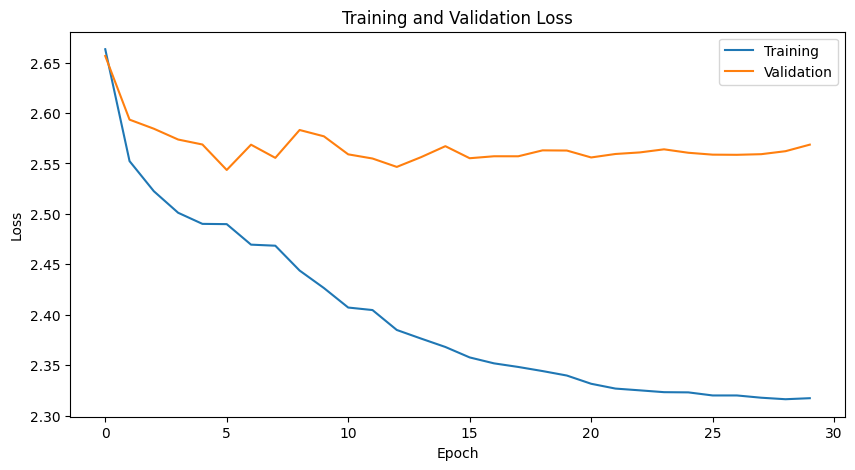

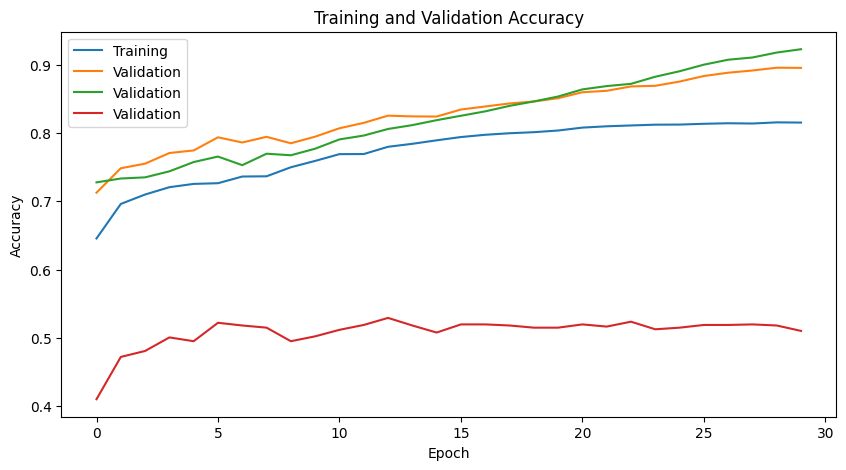

In [135]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.plot(erosion_f1, label="Validation")
plt.plot(jsn_f1, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [78]:
def bbox_to_nice_format(bbox):
    xmin, ymin, xmax, ymax = bbox[0]

    dx = (xmax-xmin)/2
    dy = (ymax-ymin)/2

    return xmin+dx, ymin+dy, dx, dy

In [79]:
test_dataset = TestImageDataset(df_test, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [80]:
bacth = next(iter(test_loader))

In [81]:
img, patient_id, joint_id, bbox = bacth

In [82]:
len(next(iter(test_dataset)))

4

In [94]:
model.to(device)
model.eval()
jsn_scores = []
erosion_scores = []
image_names = []

xcenters = []
ycenters = [] 
dxs = []
dys = []
patient_ids = []
joint_ids = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        img, patient_id, joint_id, bbox = batch
        img, joint_id, bbox = img.to(device), joint_id.to(device), bbox.to(device)
        jsn_preds, erosion_preds = model(img, joint_id, bbox)
        
        jsn = torch.argmax(jsn_preds, dim=1).item()
        erosion = torch.argmax(erosion_preds, dim=1).item()

        xcenter, ycenter, dx, dy = bbox_to_nice_format(bbox.detach().cpu().tolist())

        xcenters.append(xcenter)
        ycenters.append(ycenter)
        dxs.append(dx)
        dys.append(dy)
        jsn_scores.append(int(jsn))
        erosion_scores.append(erosion)
        patient_ids.append(patient_id[0])
        joint_ids.append(joint_id.cpu().item())

100%|██████████| 1260/1260 [00:15<00:00, 79.78it/s]


In [97]:
bbox

tensor([[   0.,    0., 5000., 5000.]], device='cuda:0')

In [100]:
submission_df = pd.DataFrame({
    'patient_id': patient_ids,
    'joint_id': joint_ids,
    'jsn_score':jsn_scores,
    'erosion_score': erosion_scores,
    'xcenter': xcenter,
    'ycenter':ycenters,
    'dx': dxs,
    'dy':dys,
    'PAD':0
})

In [103]:
submission_df['ID'] = submission_df[['patient_id','joint_id']]\
.apply(lambda x: str(x['patient_id'])+'_'+str(x['joint_id']), axis=1)

In [104]:
submission_df.to_csv('submission_df.csv', index=False)

In [ ]:
submission_df.head()

In [ ]:
submission_df.probability.value_counts()

In [ ]:
submission_df.to_csv("submit.csv", index=False)
print("Submission file generated: submit.csv")